<a href="https://colab.research.google.com/github/Trevenport/2006_WIN32_pulsar_magnitosphere_modelling/blob/main/2_cupy_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU computing using CuPy

CuPy is an open-source array library for GPU-accelerated computing with Python. CuPy utilizes CUDA Toolkit libraries including cuBLAS, cuRAND, cuSOLVER, cuSPARSE, cuFFT, cuDNN and NCCL to make full use of the GPU architecture. Most operations perform well on a GPU using CuPy out of the box, and CuPy speeds up some operations more than 100X.

## Interoperability
Many of the same numpy functions are available in cupy and numpy. You can simply swap out the 'np' for 'cp'.

In [1]:
import numpy as np
import cupy as cp

x_cpu = np.array([1, 2, 3])
l2_cpu = np.linalg.norm(x_cpu)
x_gpu = cp.array([1, 2, 3])
l2_gpu = cp.linalg.norm(x_gpu)

We cannot add together cupy and cupy arrays because they are on different devices. Numpy is on the CPU, Cupy is on the GPU

In [2]:
z = x_cpu + x_gpu

TypeError: Unsupported type <class 'numpy.ndarray'>

We need to either move the cupy array to the CPU, or move the numpy array to the GPU

In [3]:
z_gpu = cp.asarray(x_cpu) + x_gpu
z_cpu = x_cpu + cp.asnumpy(x_gpu)

Can wrap all arguments to make sure that everything is on the same device

In [4]:
z_gpu = cp.asarray(x_cpu) + cp.asarray(x_gpu)
z_cpu = cp.asnumpy(x_cpu) + cp.asnumpy(x_gpu)

PyTorch is a commonly-used machine learning framefork that provides high-performance, differentiable tensor operations. Because cupy and pytorch use the same cuda array interface, zero-copy data exchange between CuPy and PyTorch can be achieved at no cost.

**However**, PyTorch creates CPU tensors by default, which do not have a cuda array interface. **Ensure that the tensor is already on GPU before trying to exchange!**

In [5]:
import cupy as cp
import torch


# convert a torch tensor to a cupy array
a = torch.rand((3, 3), device='cuda')
b = cp.asarray(a)
b *= b
b

array([[0.11852369, 0.71776307, 0.86708367],
       [0.5979582 , 0.5405106 , 0.7564965 ],
       [0.02600268, 0.22668284, 0.3724765 ]], dtype=float32)

In [6]:
# convert a cupy array to a torch tensor
a = cp.arange(10)
b = torch.as_tensor(a, device='cuda')
b += 3
b

tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12], device='cuda:0')

## CPU/GPU agnostic code

We can also use the device detection. The following code checks if a GPU is available, then uses cupy. If there are no GPUs, it will use numpy

In [7]:
import numpy as np
import cupy as cp

if cp.cuda.runtime.getDeviceCount() == 0:
  xp = np
else: xp = cp

x = xp.random.rand(50)

We can also create functions which check what array type they receive, and use numpy or cupy appropriately

In [8]:
def softplus(x_in):
    xp = cp.get_array_module(x_in)  # 'xp' is a standard usage in the community
    print("Using:", xp.__name__)
    return xp.maximum(0, x_in) + xp.log1p(xp.exp(-abs(x_in)))

softplus(x)

Using: cupy


array([0.99055577, 1.24367777, 0.72833341, 0.91091896, 0.72744149,
       1.06040327, 0.78540759, 0.87893739, 0.69513339, 1.07669502,
       0.83049842, 0.7524825 , 1.01227374, 1.21974016, 0.71472254,
       1.28958394, 0.76305229, 1.1669868 , 1.24949164, 0.94295867,
       1.14943891, 0.70112236, 1.01427433, 0.75066285, 0.96716981,
       0.99487409, 1.26643829, 0.7592085 , 1.14570728, 1.04780931,
       0.81861393, 1.05397093, 0.8736831 , 1.07027292, 1.10893881,
       0.89724961, 1.19442425, 1.28754953, 0.96208297, 1.0403392 ,
       1.20621729, 0.7757953 , 0.73100785, 1.0974569 , 0.73238578,
       0.95429013, 1.1568634 , 0.7803792 , 1.24205233, 1.03091964])

## When to use cupy

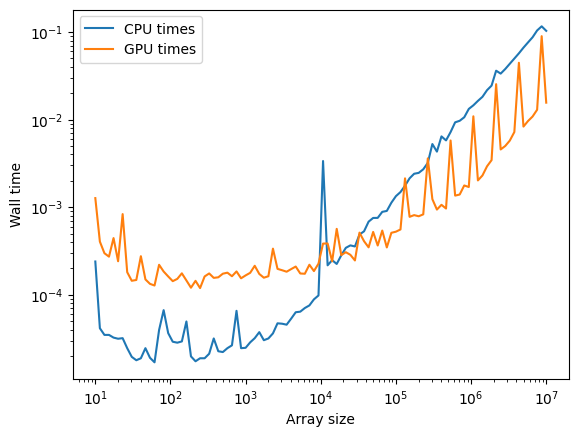

In [9]:
# it often takes more time to send data to the GPU than the CPU
%matplotlib inline
import time
import matplotlib.pyplot as plt
start = time.time()

N = np.logspace(1,7,100)#[1e2,1e3,1e4,1e5,1e6]
times_cpu = []
times_gpu = []
for n in N:
  t_cpu = time.time()
  x_cpu = np.random.rand(int(n))
  l2_cpu = np.linalg.norm(x_cpu)
  t_cpu = time.time() - t_cpu
  times_cpu.append(t_cpu)

  t_gpu = time.time()
  x_gpu = cp.array(x_cpu)
  l2_gpu = cp.linalg.norm(x_gpu)
  t_gpu = time.time() - t_gpu
  times_gpu.append(t_gpu)
plt.plot(N,times_cpu, label="CPU times")
plt.plot(N,times_gpu, label = "GPU times")
plt.xlabel("Array size")
plt.ylabel("Wall time")
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Exercise with Fast Fourier Transforms (FFTs)
We can also do FFTs on the GPU with cupy

In [10]:
import cupy as cp
import cupyx.scipy.fft as cufft

a = cp.random.random(100).astype(cp.complex64)
b =cufft.fft2(a)

The 2D Fourier transform is often used for imaging and prediction in radio astronomy.

In [11]:
import numpy as np

def ft2D(img):
    return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(img)))

def ift2D(img):
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img))))

radio_galaxy_image = np.load("true_image_83.npy")
uv_coverage_eht = np.load("EHT_mask_150.npy")

# calculate the dirty beam and dirty image
beam_dirty_EHT = ift2D(uv_coverage_eht) # LINE 1
img_dirty_EHT = ift2D(ft2D(radio_galaxy_image)*uv_coverage_eht) # LINE 2

import matplotlib.pyplot as plt
fig,axs = plt.subplots(2,2)
plt.tight_layout()
axs=axs.flatten()
axs[0].imshow(radio_galaxy_image)
axs[0].set_title("Clean image")
axs[1].imshow(uv_coverage_eht)
axs[1].set_title("EHT UV coverage")
axs[2].imshow(beam_dirty_EHT)
axs[2].set_title("Dirty beam")
axs[3].imshow(img_dirty_EHT)
axs[3].set_title("Dirty image")


FileNotFoundError: [Errno 2] No such file or directory: 'true_image_83.npy'

**Exercise 2**: reproduce the above cody using cupy instead of numpy. How does the timing compare when calculating the dirty beam and dirty image using numpy vs cupy?